In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2, feature_causal_gan
from sparse_causal_model_learner_rl.trainable.discriminator import CausalFeatureActionModelDiscriminator
from sparse_causal_model_learner_rl.trainable.fcnet import FCNet

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
from functools import partial

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin',
                   '../sparse_causal_model_learner_rl/configs/server_collect.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1',
 'kc_dec',
 '5x5_1f1c1k_obs',
 'server_collect']

In [3]:
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.rl_multistep', [])
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.minibatch_size', 5000)
gin.bind_parameter('Normalizer.type_', 'meanstd')
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', True)

In [4]:
ray.init(ignore_reinit_error=True)

2021-02-09 08:54:17,793	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:42618',
 'object_store_address': '/tmp/ray/session_2021-02-09_08-54-17_093536_36465/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-09_08-54-17_093536_36465/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-02-09_08-54-17_093536_36465',
 'metrics_export_port': 40886,
 'node_id': '36a550fbc90b5d5c6e134d4ac79547c9fe36871d'}

In [5]:
gin.bind_parameter('CausalFeatureActionModelDiscriminator.input_embedder_cls',
                   {'f_t': partial(FCNet, hidden_sizes=[], activation_cls=None, add_input_batchnorm=True),
                    'f_t1': partial(FCNet, hidden_sizes=[], activation_cls=None, add_input_batchnorm=True)
                   })
gin.bind_parameter('CausalFeatureActionModelDiscriminator.feature_embedding_dim', 30)
gin.bind_parameter('CausalFeatureActionModelDiscriminator.aggregator_cls',
                   partial(FCNet, hidden_sizes=[256, 128, 64], activation_cls=torch.nn.Tanh,
                           add_input_batchnorm=True))
gin.bind_parameter('Config.causal_feature_action_model_discriminator', CausalFeatureActionModelDiscriminator)

In [6]:
# gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
# gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [7]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [8]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-09 08:54:19,743	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 03ec6916-6aac-11eb-8ff1-90e2baa1a248
Make environment KeyChest-v0 None {}


(pid=36778) Make environment KeyChest-v0 None {}
(pid=36823) Make environment KeyChest-v0 None {}
(pid=36825) Make environment KeyChest-v0 None {}
(pid=36819) Make environment KeyChest-v0 None {}
(pid=36839) Make environment KeyChest-v0 None {}
(pid=36779) Make environment KeyChest-v0 None {}
(pid=36845) Make environment KeyChest-v0 None {}



In [9]:
learner.create_trainables()

In [10]:
learner.causal_feature_action_model_discriminator

CausalFeatureActionModelDiscriminator(
  (model_f_t): FCNet(
    (fc01): Linear(in_features=30, out_features=30, bias=True)
    (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_f_t1): FCNet(
    (fc01): Linear(in_features=32, out_features=30, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_a_t): IdentityNet()
  (agg): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bias=True)
    (fc04): Linear(in_features=64, out_features=1, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (aggregator): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bia

In [11]:
learner.model

ManyNetworkCombinedModel(
  (bn): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [12]:
learner.decoder

ModelDecoder(
  (model): FCNet(
    (fc01): Linear(in_features=847, out_features=512, bias=True)
    (fc02): Linear(in_features=512, out_features=30, bias=True)
  )
)

In [13]:
env = learner.env

In [62]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [63]:
ctx = learner.collect_and_get_context()

In [64]:
feature_causal_gan(**ctx, loss_type='generator')

{'loss': tensor(8.2029, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 3.6725335121154785,
  'loss_env_permuted': 0.1064005196094513,
  'loss_model': 4.423962593078613,
  'mean_logits_env': -3.521942377090454,
  'mean_logits_env_permuted': -4.125065326690674,
  'mean_logits_model': -4.319941520690918,
  'mse_model_pred': 2.181450128555298}}

In [65]:
feature_causal_gan(**ctx, loss_type='discriminator')

{'loss': tensor(3.8861, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 3.6725335121154785,
  'loss_env_permuted': 0.10954029113054276,
  'loss_model': 0.10402112454175949,
  'mean_logits_env': -3.521942377090454,
  'mean_logits_env_permuted': -4.1466498374938965,
  'mean_logits_model': -4.319941520690918,
  'mse_model_pred': 2.181450128555298}}

In [66]:
features = learner.decoder(ctx['obs'])

In [67]:
f = features.detach().cpu().numpy()

In [68]:
f.shape

(5000, 30)

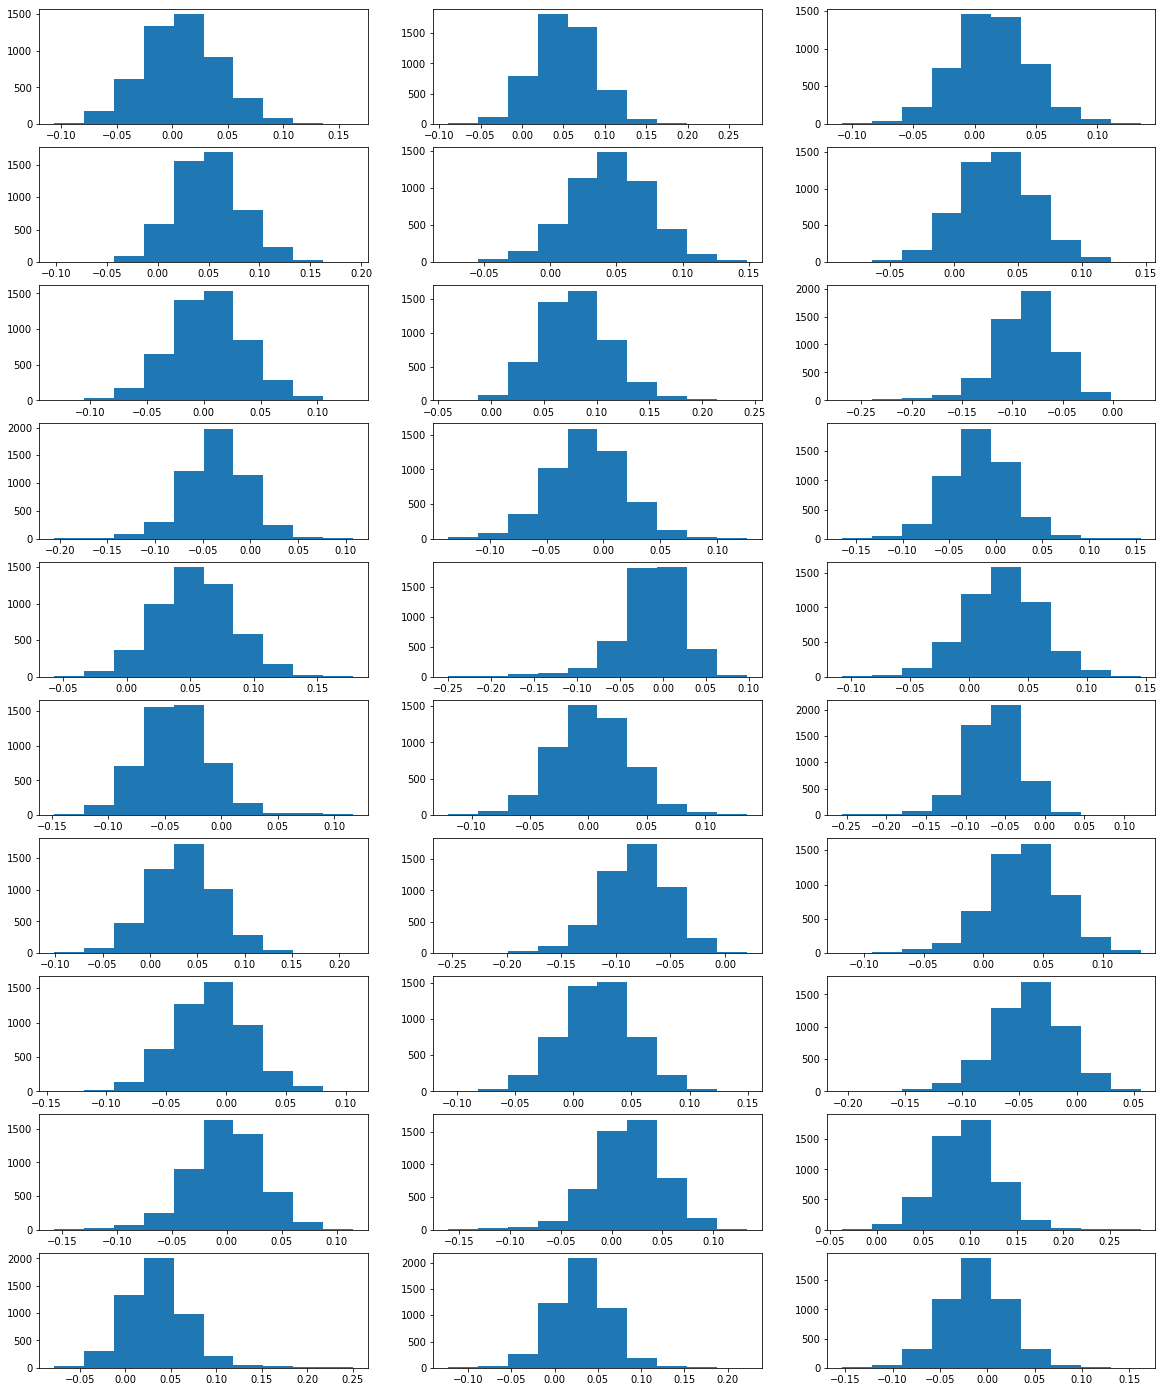

In [69]:
plt.figure(figsize=(20, 25))
for i_f in range(f.shape[1]):
    plt.subplot(10, 3, i_f + 1)
    plt.hist(f[:, i_f])

In [70]:
pd.DataFrame(f).std()

0     0.034288
1     0.037259
2     0.031110
3     0.032486
4     0.030602
5     0.029589
6     0.032969
7     0.033386
8     0.031868
9     0.032598
10    0.033310
11    0.033675
12    0.030320
13    0.038598
14    0.032587
15    0.031479
16    0.032432
17    0.034393
18    0.035666
19    0.031678
20    0.030965
21    0.031041
22    0.031658
23    0.031565
24    0.032630
25    0.034522
26    0.033228
27    0.035953
28    0.033537
29    0.033911
dtype: float32

<AxesSubplot:>

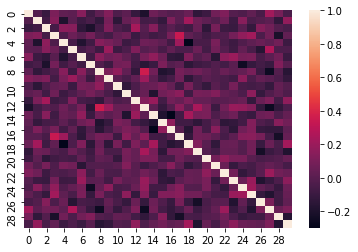

In [71]:
sns.heatmap(pd.DataFrame(f).corr())

In [72]:
env.engine.return_rgb = False

In [73]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.Tanh)
gin.bind_parameter('model_gnn/FCCombinedModel.hidden_sizes', [100, 100, 100])
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', False)

In [74]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [75]:
learner.causal_feature_action_model_discriminator.__init__(observation_shape=learner.observation_shape,
                                                           action_shape=learner.action_shape,
                                                           total_feature_shape=learner.model_kwargs['total_feature_shape'],
                         feature_shape=learner.feature_shape)
learner.causal_feature_action_model_discriminator = learner.causal_feature_action_model_discriminator.cuda()

In [76]:
learner.causal_feature_action_model_discriminator

CausalFeatureActionModelDiscriminator(
  (model_f_t): FCNet(
    (fc01): Linear(in_features=30, out_features=30, bias=True)
    (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_f_t1): FCNet(
    (fc01): Linear(in_features=32, out_features=30, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_a_t): IdentityNet()
  (agg): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bias=True)
    (fc04): Linear(in_features=64, out_features=1, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (aggregator): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bia

In [77]:
learner.non_sparse_model.model.model.activation

[Tanh(), Tanh(), Tanh(), None]

In [78]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [79]:
learner.non_sparse_model.model.enable_switch

False

In [80]:
mins = None
maxes = None

In [81]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [82]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        dim = 60
        self.bn = torch.nn.BatchNorm1d(num_features=34)
        self.fc1 = nn.Linear(in_features=34, out_features=dim)
        self.fc2 = nn.Linear(in_features=dim, out_features=dim)
        self.fc3 = nn.Linear(in_features=dim, out_features=dim)
        self.fc4 = nn.Linear(in_features=dim, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [83]:
metrics = []
losses_gen = []
losses_disc = []
losses_dec = []
ratios = []
ctx_set = False

In [84]:
use_model = learner.non_sparse_model
#use_model = AdhocWorldModel().cuda()

In [85]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [86]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [87]:
opt_disc = torch.optim.Adam(lr=1e-3, params=list(learner.causal_feature_action_model_discriminator.parameters()),# + list(learner.decoder.parameters()),
                      #amsgrad=True,
#                        betas=(0.5, 0.8)
                      )
opt_gen = torch.optim.Adam(lr=1e-3, params=list(learner.decoder.parameters()) + list(use_model.parameters()),
                      #amsgrad=True,
#                        betas=(0.5, 0.8)
                      )
opt_dec = torch.optim.Adam(lr=1e-3, params=list(learner.decoder.parameters()) + list(learner.causal_feature_action_model_discriminator.parameters()),
                      #amsgrad=True,
#                        betas=(0.5, 0.8)
                      )

In [88]:
[x.mean() for x in learner.decoder.state_dict().values()]

[tensor(3.3754e-05, device='cuda:0'),
 tensor(-0.0001, device='cuda:0'),
 tensor(0.0001, device='cuda:0'),
 tensor(-0.0012, device='cuda:0'),
 tensor(-0.0002, device='cuda:0'),
 tensor(-0.0113, device='cuda:0')]

In [89]:
feature_causal_gan(**ctx, loss_type='generator')

{'loss': tensor(2.1165, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 0.7268704771995544,
  'loss_env_permuted': 0.6619371175765991,
  'loss_model': 0.7276572585105896,
  'mean_logits_env': -0.06524041295051575,
  'mean_logits_env_permuted': -0.06492018699645996,
  'mean_logits_model': -0.0664881020784378,
  'mse_model_pred': 2.1923446655273438}}

In [122]:
epochs = 500000
with tqdm(total=epochs) as pbar:
    for i in range(epochs):
        if i % 1 == 0 or not ctx_set:
            ctx_set = True
            ctx = learner.collect_and_get_context()
            ratio = ctx.get('context_stats_collected_sampled_ratio', None)
            if ratio:
                ratios.append(ratio)
            elif ratios:
                ratios.append(ratios[-1])

        ctx['non_sparse_model_add'] = use_model
        
        feature_causal_gan(**ctx, loss_type='generator')
        
        def get_loss_obj(loss_type):
            l_obj_fit = context_rewriter(function=feature_causal_gan, rewrite={'model': 'non_sparse_model_add'},
                                         **ctx,
                                         loss_type=loss_type,
                                         add_mse_coeff=1.0)
            return l_obj_fit
        
        
        l_obj_disc = get_loss_obj('discriminator')
        l_obj_gen = get_loss_obj('generator')
        l_obj_dec = get_loss_obj('only_contrastive')

        stage = (i // 50) % 3
        if stage == 0:
            # contrastive loss training
            loss = l_obj_dec['loss']
            
            opt_dec.zero_grad()
            loss.backward()
            opt_dec.step()
        elif stage == 2:
            # discriminator training
            
            loss = l_obj_disc['loss']
            
            opt_disc.zero_grad()
            loss.backward()
            opt_disc.step()
        elif stage == 1:
            # generator training
            loss = l_obj_gen['loss']
            
            opt_gen.zero_grad()
            loss.backward()
            opt_gen.step()
    
        losses_gen.append(l_obj_gen['loss'].item())
        losses_disc.append(l_obj_disc['loss'].item())
        losses_dec.append(l_obj_dec['loss'].item())
        m = {}
        m.update(l_obj_disc['metrics'])
        metrics.append(m)
        pbar.update(1)
        pbar.set_postfix(loss_gen=losses_gen[-1], loss_disc=losses_disc[-1], stage=stage, loss_dec=losses_dec[-1],
                         mse=metrics[-1]['mse_model_pred'])

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

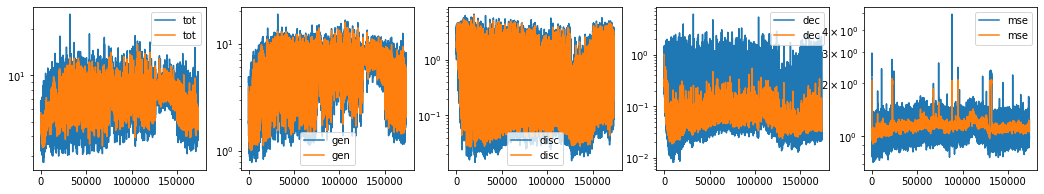

2021-02-09 22:53:49,839	ERROR worker.py:999 -- print_logs: Connection closed by server.
2021-02-09 22:53:49,867	ERROR import_thread.py:89 -- ImportThread: Connection closed by server.
2021-02-09 22:53:49,869	ERROR worker.py:1093 -- listen_error_messages_raylet: Connection closed by server.


In [123]:
metrics_dct = lstdct2dctlst(metrics)

# gan
plt.figure(figsize=(18, 3))
plt.subplot(1, 5, 1)
losses = np.array(losses_gen) + losses_disc
plt.plot(losses, label='tot')
plt.plot(pd.Series(losses).rolling(50).median(), label='tot')
plt.legend()
plt.yscale('log')

plt.subplot(1, 5, 2)
plt.plot(losses_gen, label='gen')
plt.plot(pd.Series(losses_gen).rolling(50).median(), label='gen')
plt.legend()
plt.yscale('log')
plt.subplot(1, 5, 3)
plt.plot(losses_disc, label='disc')
plt.plot(pd.Series(losses_disc).rolling(50).median(), label='disc')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

plt.subplot(1, 5, 4)
plt.plot(losses_dec, label='dec')
plt.plot(pd.Series(losses_dec).rolling(50).median(), label='dec')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

plt.subplot(1, 5, 5)
plt.plot(metrics_dct['mse_model_pred'], label='mse')
plt.plot(pd.Series(metrics_dct['mse_model_pred']).rolling(50).median(), label='mse')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

Text(0, 0.5, 'fit loss')

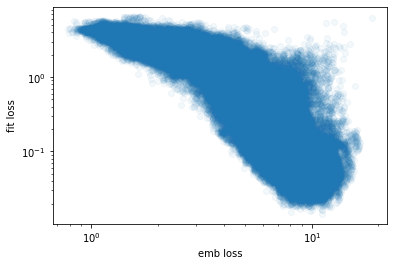

In [111]:
plt.scatter(losses_gen, losses_disc, alpha=0.05)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('emb loss')
plt.ylabel('fit loss')

In [112]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [113]:
%load_ext jupyternotify
%autonotify -a 30

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [114]:
f_t1 = learner.decoder(ctx['obs_y'])#.detach()
f_t = learner.decoder(ctx['obs_x'])#.detach()

#         f_t1 = normalize(f_t1, mins, maxes)
#         f_t = normalize(f_t, mins, maxes)

add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
# f_t1 = torch.zeros_like(f_t1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

f_t1_pred = use_model(
f_t,
ctx['action_x'],
all=True)


<AxesSubplot:>

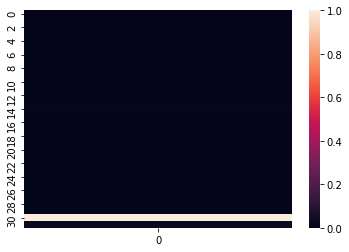

In [115]:
sns.heatmap((f_t1_pred - f_t1).pow(2).mean(0).cpu().detach().numpy().reshape(-1, 1), vmin=0)

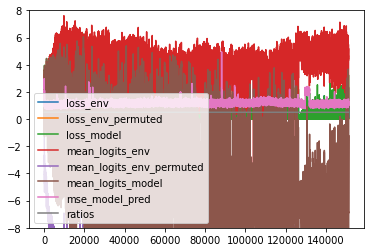

In [116]:
metrics_dct['ratios'] = ratios
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.ylim((-8, 8))
plt.legend()
plt.show()

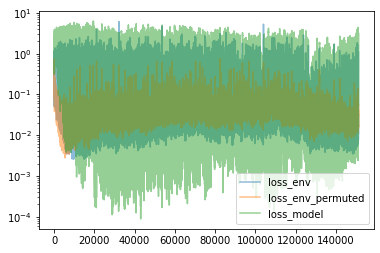

In [117]:
for key, vals in metrics_dct.items():
    if 'loss' not in key: continue
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key, alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()

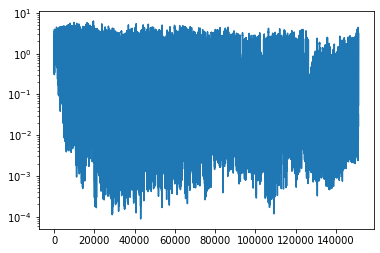

In [118]:
plt.plot(metrics_dct['loss_model'])
plt.yscale('log')

In [119]:
learner.decoder(ctx['obs_x']).min()

tensor(-0.6824, device='cuda:0', grad_fn=<MinBackward1>)

<AxesSubplot:>

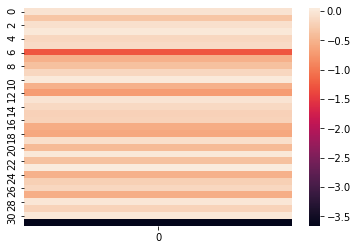

In [120]:
sns.heatmap(np.log(((f_t1_pred - f_t1).pow(2).mean(0) / f_t1.std(0).pow(2)).cpu().detach().numpy().reshape(-1, 1)))

<AxesSubplot:>

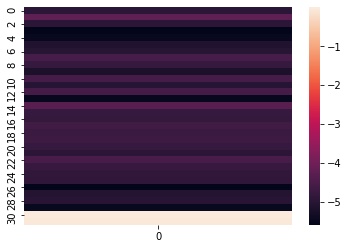

In [121]:
sns.heatmap(np.log(f_t1.std(0).pow(2).cpu().detach().numpy().reshape(-1, 1)))